In [1]:
import pandas
from pandas import DataFrame, Series
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from random import randint, seed
seed(12345)
import matplotlib.pyplot as plt


#### Construct the DataFrames for analysis

In [2]:
#You might need to change the file names to include a path
cups = pandas.read_csv('WorldCups.csv')
players = pandas.read_csv('WorldCupPlayers.csv')
matches = pandas.read_csv('WorldCupMatches.csv')

In [3]:
players = players.merge(matches[['Year', 'RoundID', 'MatchID']], on=['RoundID', 'MatchID'])

In [4]:
# I add PlayerID to make calculating squad experience easier.
# We shirt numbers for all and only teams after 1953. Before 1953, all players are recorded as shirt number = 0.
for row in players.index:
    players.loc[row, 'PlayerID'] = (players.loc[row, 'Team Initials'] + 
                                    players.loc[row, 'Player Name'] + 
                                    str(int(players.loc[row, 'Shirt Number'])))
    

In [5]:
players = players.drop_duplicates()

In [6]:
matches = matches.drop_duplicates()[:-1] #The -1 drops a blank row at the end of the table

In [7]:
# Both cups and players have a column named Attendance but they refer to different things.
# We want unique column name for when we merge all three data sets
cups = cups.rename(columns={'Attendance':'Cups Attendance'})

In [8]:
# Merge players and matches on their intersecting column names
data = players.merge(matches, on=['RoundID', 'MatchID', 'Year'])

In [9]:
data = data.merge(cups, on='Year').drop_duplicates() # We now have a data set with 36 columns and 37048 rows

In [10]:
#add the columns to be filled.
data['Event Type'] = Series()
data['Event Time'] = Series()

In [11]:
# Create a dataframe for players with non-null Event
accumulator = {}
index = 0
for i in data[data['Event'].isnull()==False].index:
    events = data.loc[i]['Event'].split(' ')
    for event in events:
        accumulator[index] = Series(data.loc[i])
        accumulator[index]['Event Type'] = ''.join([ch for ch in event if ch.isalpha()])
        accumulator[index]['Event Time'] = ''.join([ch for ch in event if ch.isdigit()])
        index += 1
event_data = DataFrame.from_dict(accumulator, orient='index')

In [12]:
# Create a dataframe for players with null Event and merge with the rest
nanevents = data[data['Event'].isnull()==True] 
data1 = pandas.concat([nanevents, event_data], axis=0, ignore_index=True)
# data1 gives all the events of each match

In [13]:
coaches = data1[['MatchID', 'Coach Name', 'Team Initials']].drop_duplicates()

In [14]:
#our data set was missing this info. Without it there was no way to tell which team won. Info from wikipedia
matches.loc[35, "Win conditions"] = 'Switzerland win on penalties (4 - 2)'
matches.loc[28, "Win conditions"] = 'Italy win on penalties (1 - 0)'
matches.loc[38, "Win conditions"] = 'Cuba win on penalties (2 - 1)'
matches.loc[44, "Win conditions"] = 'Brazil win on penalties (2 - 1)'
matches.loc[456, "Win conditions"] = 'Argentina win on penalties (3 - 2)'
matches.loc[460, "Win conditions"] = 'Argentina win on penalties (4 - 3)'
matches.loc[461, "Win conditions"] = 'Germany FR win on penalties (4 - 3)'
matches.loc[357, "Win conditions"] = 'Germany FR win on penalties (5 - 4)'
matches.loc[452, "Home Team Name"] = 'Republic of Ireland'

In [15]:
set(list(matches['Stage']))

{'Final',
 'First round',
 'Group 1',
 'Group 2',
 'Group 3',
 'Group 4',
 'Group 5',
 'Group 6',
 'Group A',
 'Group B',
 'Group C',
 'Group D',
 'Group E',
 'Group F',
 'Group G',
 'Group H',
 'Match for third place',
 'Play-off for third place',
 'Preliminary round',
 'Quarter-finals',
 'Round of 16',
 'Semi-finals',
 'Third place'}

In [16]:
def beats(teama: dict, teamb: dict, i: int, index: int, home: bool) -> None:
    """teama beats teamb. home = teama == the home team.
    
    Precondition: teama and teamb both contain Name and Initials
    """
    winners[index]['Team'] = teama['Name']
    winners[index]['Team Initials'] = teama['Initials']
    winners[index]['Opponent Name'] = teamb['Name']
    winners[index]['Opponent Initials'] = teamb['Initials']
    losers[index]['Team'] = teamb['Name']
    losers[index]['Team Initials'] = teamb['Initials']
    losers[index]['Opponent Name'] = teamb['Name']
    losers[index]['Opponent Initials'] = teamb['Initials']
    if home:
        winners[index]['Goals For'] = matches.loc[i]['Home Team Goals']
        winners[index]['Goals Against'] = matches.loc[i]['Away Team Goals']
        losers[index]['Goals For'] = matches.loc[i]['Away Team Goals']
        losers[index]['Goals Against'] = matches.loc[i]['Home Team Goals']
    else:
        winners[index]['Goals For'] = matches.loc[i]['Away Team Goals']
        winners[index]['Goals Against'] = matches.loc[i]['Home Team Goals']
        losers[index]['Goals For'] = matches.loc[i]['Home Team Goals']
        losers[index]['Goals Against'] = matches.loc[i]['Away Team Goals']
    
stages = ['Final', 'First round', 'Match for third place', 'Play-off for third place', \
          'Preliminary round', 'Quarter-finals', 'Round of 16','Semi-finals','Third place'] #elim rounds only
winners = {}
losers = {}
index = 0
problems = {}
# Removed the restriction on the years so we can test for all years (RM)
for i in matches.index:
    winners[index] = Series(matches.loc[i])
    losers[index] = Series(matches.loc[i])

    hometeam = {"Name": matches.loc[i]['Home Team Name'], 
                "Initials": matches.loc[i]['Home Team Initials']}
    awayteam = {"Name": matches.loc[i]['Away Team Name'], 
                "Initials": matches.loc[i]['Away Team Initials']}
    if matches.loc[i]['Stage'] in stages:
        # home team beats away team
        if matches.loc[i]['Home Team Goals'] > matches.loc[i]['Away Team Goals']:
            beats(hometeam, awayteam, i, index, True) 
        
        # away team beats home team
        elif matches.loc[i]['Home Team Goals'] < matches.loc[i]['Away Team Goals']:
            beats(awayteam, hometeam, i, index, False) 
            
        # home team beats away team    
        elif hometeam['Name'] in matches.loc[i]['Win conditions']:
            beats(hometeam, awayteam, i, index, True) 
            
        elif awayteam['Name'] in matches.loc[i]['Win conditions']:
            beats(awayteam, hometeam, i, index, False) 
            
        # away team beats home team    
        else:
            problems[index] = Series(matches.loc[i])
            
    index +=1
for i in winners:
    winners[i]['Win'] = True
    losers[i]['Win'] = False

teams = pandas.concat([DataFrame.from_dict(winners, orient='index'), DataFrame.from_dict(losers, orient='index')],\
                      axis=0, ignore_index=True)

In [17]:
problems #Yay, no problems! Every team which I expected to have a winner and a loser has a winner and a loser.

{}

In [18]:
teams['Home'] = teams['Team Initials'] == teams['Home Team Initials']

In [19]:
for row in teams.index:
    if teams.loc[row, 'Team'] == 'rn">Republic of Ireland':
        teams.loc[row, 'Team'] = 'Republic of Ireland'

In [20]:
# Remove unncessary columns to aid runtime.
teams = teams[['Team', 'Team Initials', 'Win', 'Home','Goals For', 'Goals Against',
       'Win conditions', 'Referee','Opponent Name','Opponent Initials', 'MatchID', 'Year', 'Datetime', 'Stage']] 

In [21]:
teams = teams.merge(coaches, on=['Team Initials', 'MatchID'])

In [22]:
coach_countries = [teams.loc[i]['Coach Name'][-4:-1] for i in teams.index]

In [23]:
teams['Coach Country'] = Series(coach_countries, index=teams.index)

In [24]:
teams['Foreign Coach'] = teams['Team Initials'] != teams['Coach Country']

In [25]:
for string in ['Y', 'RSY', 'R', 'I', 'IH']:
    strings = []
    for i in teams.index:
        strings.append(len(data1[(data1['MatchID']==teams.loc[i]['MatchID'])\
                                 & (data1['Team Initials']==teams.loc[i]['Team Initials'])\
                                 & (data1['Event Type']==string)]))
    teams[string] =  Series(strings, index=teams.index)    

In [26]:
teams['All Cards'] = teams['Y'] + teams['R']

In [27]:
teams = teams.merge(cups[['Year', 'Country']], on='Year')

In [28]:
teams.rename(columns={"Country":"Host Country"}) # Rename just for clarity

,Team,Team Initials,Win,Home,Goals For,Goals Against,Win conditions,Referee,Opponent Name,Opponent Initials,...,Coach Name,Coach Country,Foreign Coach,Y,RSY,R,I,IH,All Cards,Host Country
0,Argentina,ARG,True,True,6.0,1.0,,LANGENUS Jean (BEL),USA,USA,...,OLAZAR Francisco (ARG),ARG,False,0,0,0,0,0,0,Uruguay
1,Uruguay,URU,True,True,6.0,1.0,,REGO Gilberto (BRA),Yugoslavia,YUG,...,SUPPICI Alberto (URU),URU,False,0,0,0,0,0,0,Uruguay
2,Uruguay,URU,True,True,4.0,2.0,,LANGENUS Jean (BEL),Argentina,ARG,...,SUPPICI Alberto (URU),URU,False,0,0,0,0,0,0,Uruguay
3,USA,USA,False,False,1.0,6.0,,LANGENUS Jean (BEL),USA,USA,...,MILLAR Bob (USA),USA,False,0,0,0,0,0,0,Uruguay
4,Yugoslavia,YUG,False,False,1.0,6.0,,REGO Gilberto (BRA),Yugoslavia,YUG,...,SIMONOVIC Bosko (YUG),YUG,False,0,0,0,0,0,0,Uruguay
5,Argentina,ARG,False,False,2.0,4.0,,LANGENUS Jean (BEL),Argentina,ARG,...,OLAZAR Francisco (ARG),ARG,False,0,0,0,0,0,0,Uruguay
6,Austria,AUT,True,True,3.0,2.0,Austria win after extra time,VAN MOORSEL Johannes (NED),France,FRA,...,MEISL Hugo (AUT),AUT,False,0,0,0,0,0,0,Italy
7,Hungary,HUN,True,True,4.0,2.0,,BARLASSINA Rinaldo (ITA),Egypt,EGY,...,NADAS Odon (HUN),HUN,False,0,0,0,0,0,0,Italy
8,Switzerland,SUI,True,True,3.0,2.0,,EKLIND Ivan (SWE),Netherlands,NED,...,MUELLER Henry (SUI),SUI,False,0,0,0,0,0,0,Italy
9,Sweden,SWE,True,True,3.0,2.0,,BRAUN Eugen (AUT),Argentina,ARG,...,NAGY Joszef (HUN),HUN,True,0,0,0,0,0,0,Italy


In [29]:
# recode the date time field (RM)
teams['newDateTime'] = pandas.to_datetime(teams.Datetime)

In [30]:
# Wins and Losses columns for each team going into each match (JC)
teams['Wins'] = 0
teams['Losses'] = 0
for row in teams.index:
    teamname = teams.loc[row, 'Team']
    teaminitials = teams.loc[row, 'Team Initials']
    currenttime = teams.loc[row, 'newDateTime']
    
    teams.loc[row, 'Wins'] = len(teams[(teams['Team']==teamname)&(teams['Team Initials']==teaminitials)&\
                                      (teams['Win']==True)&(teams['newDateTime']<currenttime)])
    teams.loc[row, 'Losses'] = len(teams[(teams['Team']==teamname)&(teams['Team Initials']==teaminitials)&\
                                      (teams['Win']==False)&(teams['newDateTime']<currenttime)])
    
teams['Games Played'] = teams['Wins'] + teams['Losses']
for row in teams.index:
    if teams.loc[row, 'Games Played'] == 0:
        # I decided on filling NaNs with 0 because it gives the best accuracy, according to the code below.
        teams.loc[row, 'WinLoss%'] = 0
    else:    
        teams.loc[row, 'WinLoss%'] = teams.loc[row, 'Wins']/teams.loc[row, 'Games Played']
                                         
teams['All Substitutions'] = teams['IH'] + teams['I']

teams['Foreign Soil'] = teams['Country'] == teams['Team']

In [31]:
any(teams['WinLoss%'].isnull()) # This is just a quick sanity check

False

#### The next two blocks of code determine the cumulative team (i.e., man-match) experience

In [32]:
rosters = {}
problems = {}
for i in teams.index:
    teaminitials = teams.loc[i, 'Team Initials']
    matchid = teams.loc[i, 'MatchID']
    startingroster = players[(players['MatchID']==matchid)\
                     &(players['Team Initials']==teaminitials)\
                     &(players['Line-up']=='S')]['PlayerID']
## I'm not sure it's right to count players who sub in for two reasons.
## One is that I think we should focus on stats going into a match and not during. (We've so far ignored goals during a match.)
## We elsewhere determined that substitutions weren't a good predictor of match outcomes.
#
    subinroster = data1[(data1['MatchID']==matchid)&\
                       (data1['Team Initials']==teaminitials)&\
                       ((data1['Event Type']=='I')|(data1['Event Type']=='IH'))]['PlayerID']

    rosters[i] = list(startingroster) + list(subinroster)
    if len(startingroster) != 11:
        problems[i] = list(startingroster)
starting11 = Series(rosters, index=rosters.keys())
# I apologize for calling this starting11. It's actually starting11 plus everyone who subbed in.
teams['Starting11'] = starting11
problems #Yes! No problems! Every team  definitely had 11 players for their starting 11!

{}

In [33]:
starting11s = teams[['newDateTime', 'Starting11', 'Team Initials']]

xp = {}
for i in teams.index:
    teaminitials = teams.loc[i, 'Team Initials']
    matchtime = teams.loc[i, 'newDateTime']
    teamxp = 0
    for player in teams.loc[i, 'Starting11']:
        slice_ = starting11s[(starting11s['newDateTime']<matchtime)&
                             (starting11s['Team Initials']==teaminitials)]
        for row in slice_.index:
            if player in slice_.loc[row, 'Starting11']:
                teamxp += 1
        
    xp[i] = teamxp 
xp_series = Series(xp, index=xp.keys())
teams['XP'] = xp_series

In [34]:
#Both of these give True
print(1 == teams['Goals For'].median())
print(1.6074766355140186 == sum(teams['Goals Against'])/len(teams))

True
True


In [35]:
for i in teams.index:
    matchtime = teams.loc[i, 'newDateTime']
    teaminitials = teams.loc[i, 'Team Initials']
    goalsfor = sum(teams[(teams['newDateTime']<matchtime)&(teams['Team Initials']==teaminitials)]['Goals For'])
    goalsagainst = sum(teams[(teams['newDateTime']<matchtime)&(teams['Team Initials']==teaminitials)]['Goals Against'])
    matchesplayed = len(teams[(teams['newDateTime']<matchtime)&(teams['Team Initials']==teaminitials)])
    if matchesplayed == 0:
        # To avoid division by zero and allow for analysis I fill with 1 (the median goals-for/match). 
        # I also tried filling with 0, 2, and 1.6074766355140186 (the mean goals-for/match).
        # 1 seams to give the best results
        teams.loc[i, 'Goals For/Match'] = 1
        teams.loc[i, 'Goals Against/Match'] = 1
    else:    
        teams.loc[i, 'Goals For/Match'] = goalsfor/matchesplayed
        teams.loc[i, 'Goals Against/Match'] = goalsagainst/matchesplayed
        

#### Next we determine the Coach XP

In [36]:
teams.sort_values('XP',ascending=False)[['Team','Year','XP','Stage']]

,Team,Year,XP,Stage
404,Germany,2014,87,Final
402,Germany,2014,77,Semi-finals
401,Germany,2014,59,Quarter-finals
393,Germany,2010,48,Semi-finals
216,Argentina,1990,47,Semi-finals
315,Brazil,2002,46,Final
379,Spain,2010,45,Final
299,Brazil,1998,44,Final
219,Germany FR,1990,44,Final
399,Germany,2014,43,Round of 16


In [37]:
# This isn't working right yet, and I don't know why
for i in teams.index:
    if i == 0 or i == 228:
        print(i)
    matchtime = teams.loc[i, 'newDateTime']
    teaminitials = teams.loc[i, 'Team Initials']
    coachname = teams.loc[i, 'Coach Name']
    coach_xp = len(teams[(teams['Team Initials']==teaminitials)
                         &(teams['Coach Name']==coachname)
                         &(teams['newDateTime']<matchtime)])
    teams['Coach XP'] = coach_xp
    

0
228


In [38]:
teaminitials

'USA'

#### #Wins Data

In [39]:
teamsset = set(teams['Team'])
matchwins = DataFrame([len(teams[(teams['Team']==m)&(teams['Win']==True)]) for m in teamsset],
                      index=teamsset, columns=['MatchWins'])
matchlosses = Series([len(teams[(teams['Team']==m)&(teams['Win']==False)]) for m in teamsset],
                      index=teamsset)
matchwins['MatchLosses'] = matchlosses
matchwins['WinPercent'] = round(100*matchwins.MatchWins / matchwins.sum(axis=1))
matchwins = matchwins.sort_values(by='MatchWins',ascending=False)
top20 = list(matchwins.index)[:20]
top20wins = list(matchwins.MatchWins)[:20]
matchwins.head(20)
# matchwins.to_csv('MatchWins.csv')

,MatchWins,MatchLosses,WinPercent
Brazil,30,11,73.0
Italy,24,7,77.0
Germany,18,8,69.0
Germany FR,17,7,71.0
Argentina,15,9,62.0
France,14,8,64.0
Netherlands,9,11,45.0
England,8,10,44.0
Spain,8,7,53.0
Sweden,7,7,50.0


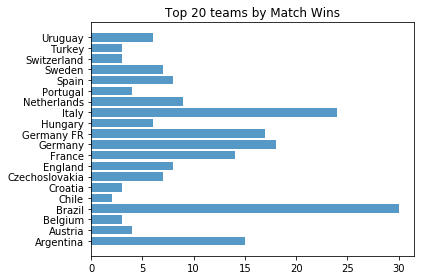

In [40]:
top20list = [x for x in top20]
top20winslist = [y for y in top20wins]
plt.barh(top20list, top20winslist, alpha=.75)
plt.title("Top 20 teams by Match Wins")
plt.tight_layout()
# plt.savefig("Top 20 teams by Match Wins", dpi=600)

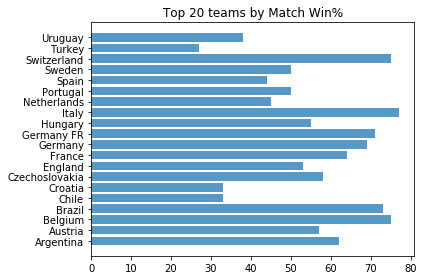

In [41]:
matchwins.sort_values(by="WinPercent")
plt.barh(list(matchwins.index)[:20], matchwins.sort_values(by='MatchWins',ascending=False).WinPercent[:20], alpha=.75)
plt.title("Top 20 teams by Match Win%")
plt.tight_layout()
# plt.savefig("Top 20 teams by Match Win%", dpi=600)

#### Home WinsLosses Data

In [42]:
hw = len(teams[(teams['Win']==True)&(teams['Home']==True)])
hl = len(teams[(teams['Win']==False)&(teams['Home']==True)])
aw = len(teams[(teams['Win']==True)&(teams['Home']==False)])
al = len(teams[(teams['Win']==False)&(teams['Home']==False)])
homewins = DataFrame([[hw,hl],[aw,al]], index=['Home', 'Away'], columns=['Wins', 'Losses'])
homewins['WinsPercent']=round(100*homewins['Wins']/(homewins.Wins + homewins.Losses))
homewins['LossesPercent']=100-homewins['WinsPercent']
# homewins[['Wins','Losses']].to_csv("WinsLossesTable.csv")

In [43]:
# plt.bar(x=['Wins', 'Losses'], height=homewins.loc['Home', ['WinsPercent', 'LossesPercent']],alpha=0.6,linestyle='dotted')
# plt.hlines(y=50,xmin=-.5,xmax=1.5,linestyle='dotted')
# plt.title("Home team Wins vs Losses (%)")
# plt.savefig('WinsLosses',dpi=600)

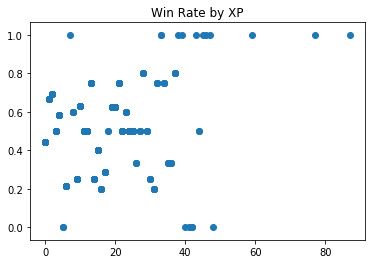

In [61]:
xpwinloss = DataFrame()
xpwinloss['XP'] = list(teams['XP'])
for x in xpwinloss.index:
    xpwinloss.loc[x, 'Wins'] = len(teams[(teams['Win']==True)&(teams['XP']==xpwinloss.loc[x,'XP'])])
    xpwinloss.loc[x, 'Losses'] = len(teams[(teams['Win']==False)&(teams['XP']==xpwinloss.loc[x,'XP'])])
xpwinloss['WinPercent'] = xpwinloss['Wins']/(xpwinloss.Wins + xpwinloss.Losses)
plt.scatter(xpwinloss.XP, xpwinloss.WinPercent)
plt.title("Win Rate by XP")
# plt.savefig("WinLoss by XP", dpi=600)

In [59]:
import statsmodels.api as sm
predictors = DataFrame(xpwinloss.XP)
target = DataFrame(xpwinloss.WinPercent)
predictors = sm.add_constant(predictors) # I don't actually understand this step
model = sm.OLS(target, predictors).fit() # I don't really understand this step either
predictions = model.predict(predictors) # nor this one
  
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             WinPercent   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     27.09
Date:                Tue, 24 Jul 2018   Prob (F-statistic):           3.02e-07
Time:                        10:51:52   Log-Likelihood:                 139.88
No. Observations:                 428   AIC:                            -275.8
Df Residuals:                     426   BIC:                            -267.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4609      0.011     40.725      0.0

/home/osheng/Buntrock/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


87

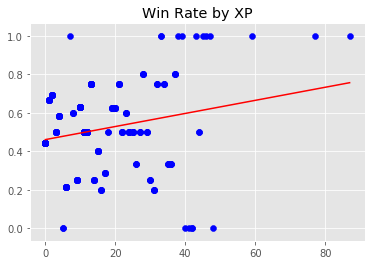

In [71]:
slope = 0.0034
yint = 0.4609
regression_line = []
for x in range(max(teams['XP'])+1):
    regression_line.append((slope*x)+yint)
from matplotlib import style
style.use('ggplot')
plt.scatter(xpwinloss.XP, xpwinloss.WinPercent,color='blue')
plt.title("Win Rate by XP")
plt.plot(range(max(teams['XP'])+1), regression_line,color='red')
# plt.savefig("Win Rate by XP", dpi=600)
plt.show()


# Analysis of all relavent variables

In [73]:
# analyze('Wins')['Model'].to_csv("Wins Model.csv")
# analyze('Games Played')['Model'].to_csv("Games Played.csv")

In [66]:
def analyze(column: str) -> dict:
    """Analyze a variable and return a dictionary of everything we might use out of that analysis"""
    output = {}
    pandas.crosstab(teams_train[column], teams_train.Win, margins = False).T
    
    
    X_train_column = pandas.DataFrame(teams_train[column])
    y_train_column = teams_train.Win
    #create the test set for 2014 (RM)
    X_test_column = pandas.DataFrame(teams_test[column])
    y_test_column = teams_test.Win
    # load the scikit learn logistic regression tool (p 397 to 400 of the text (RM))
    model_column = LogisticRegression()
    # run the regression to create the model (RM)
    # I don't now what the output means
    model_column.fit(X_train_column,y_train_column)
    output['model_column'] = model_column
    # here is the model 
    # pretty much, if you get more than 2 cards, you are going to lose.
    
    size = sorted(list(set(X_train_column[column])))
    model_input_column = pandas.DataFrame(size, index=size)
    pred_win_column = pandas.Series(model_column.predict(model_input_column))
    pandas.DataFrame({'Num '+column:model_input_column[0],'Predicted Win':pred_win_column})
    output['Model'] = pandas.DataFrame({'Num '+column:model_input_column[0],'Predicted Win':pred_win_column})
    # here are the model probabilities
    probarray_column = model_column.predict_proba(model_input_column)
    
    probdf_column = pandas.DataFrame(probarray_column,columns = ['Not Win','Win'], index=size)
    output['probdf_column'] = probdf_column
    # this is the probability chart
    # run the model on the 2014 data (RM)
    y_predict_column = model_column.predict(X_test_column)
    

    #turn the results into a series (RM)
    y_predSer_column = pandas.Series(y_predict_column ,index = X_test_column.index)

    # create a data frame based on the results (RM)
    ModelAccuracy_column = pandas.DataFrame({'Actual': y_test_column,'Prediction':y_predSer_column,
                                      'Accuracy':y_test_column == y_predSer_column,column:X_test_column[column]})
    output['ModelAccuracy_column'] = ModelAccuracy_column[[column,'Actual','Prediction','Accuracy']]
    # calculate how accurate the model was for the 2014 world cup (RM)
    # looks like the number of games played is irrelevant. 
    output['Accuracy'] = sum(ModelAccuracy_column.Accuracy) / len(ModelAccuracy_column.Accuracy)
    
    return output
    
    


In [78]:
accuracy_data = {}
variables = ['WinLoss%','Games Played','Wins', 'Losses', 'Foreign Coach','All Substitutions', \
             'IH', 'I', 'Y', 'R', 'All Cards','Home','Foreign Soil', 'XP', 'Goals For/Match', \
             'Goals Against/Match'] 
total = {}
for variable in variables:
    total[variable] = DataFrame()
seed(12345)
iterations = 1111
for i in range(iterations): # at range(1000) this takes my computer a good six or seven minutes of solid thinking
    # reduce teams by half, randomly choosing one team from each match
    accumulator = {}
    index = 0
    for id_ in list(set(teams[teams['Year']>1953]['MatchID'])):
        match = teams[teams['MatchID']==id_]
        accumulator[index] = match.iloc[randint(0,1)]
        index += 1

    halfteams = DataFrame.from_dict(accumulator, orient='index')
    # split out the training dataset and the test data base
    teams_train = halfteams[halfteams['Year'] < 2013]
    teams_test  = halfteams[halfteams['Year'] > 2013]
    
    variable_accuracies = []
    for variable in variables:
        analysis = analyze(variable)
        total[variable][i] = analysis['probdf_column'].Win
        variable_accuracies.append(analysis['Accuracy'])
    accuracy_data[i] = Series([(100*x) for x in variable_accuracies], index=variables)
    

accuracies = DataFrame.from_dict(accuracy_data, orient='columns')
accuracies['Mean'] = accuracies.mean(axis=1)

    
for variable in variables:
    total[variable]['Mean'] = total[variable].mean(axis=1)

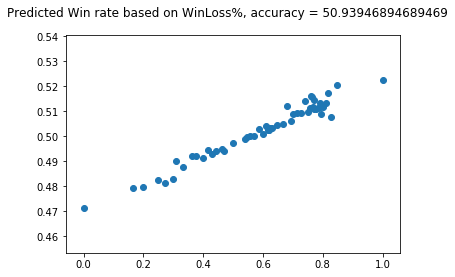

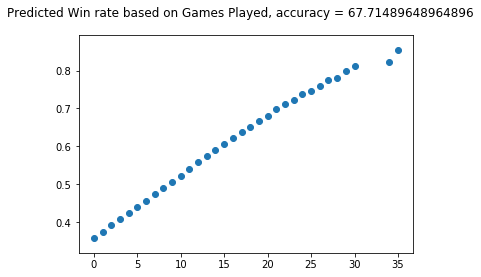

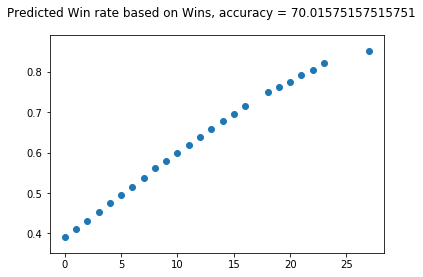

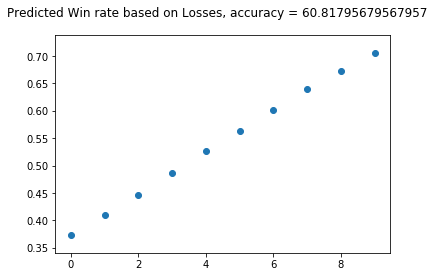

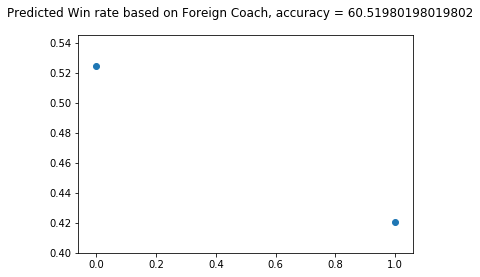

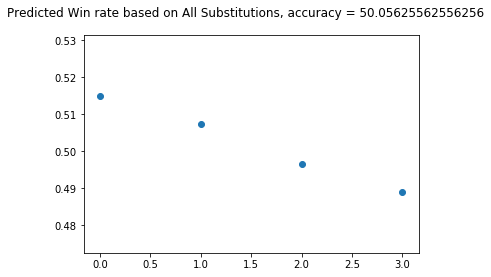

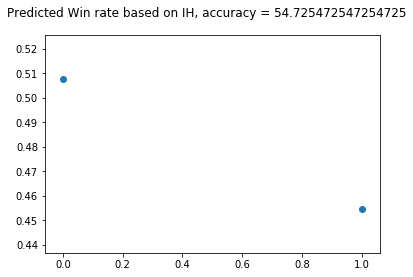

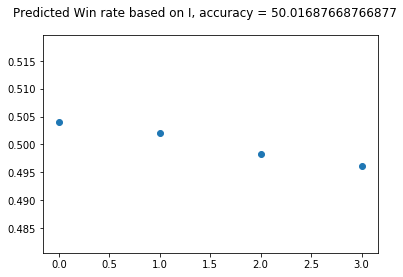

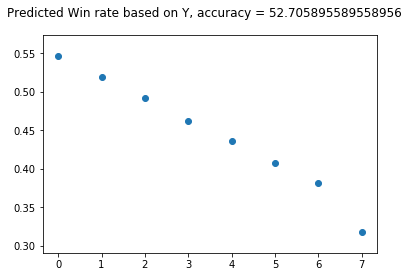

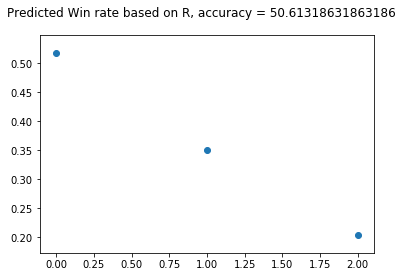

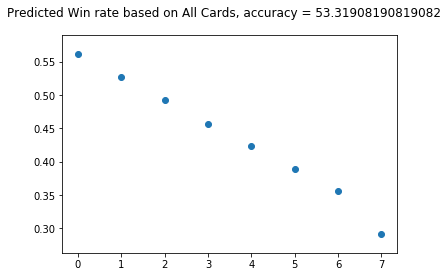

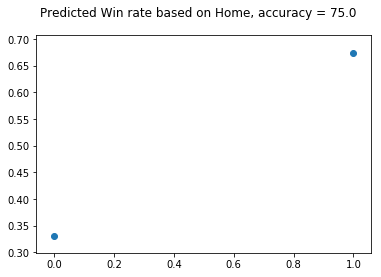

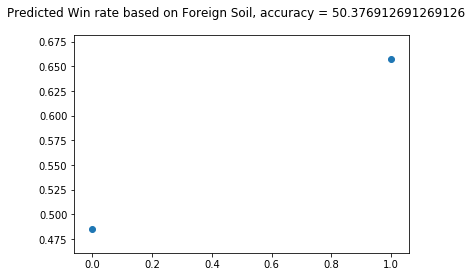

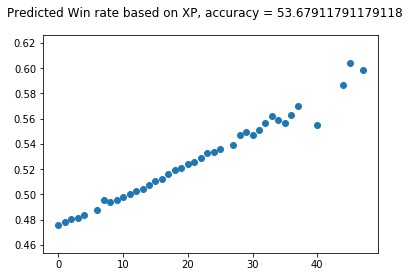

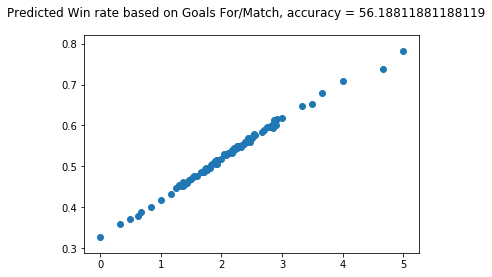

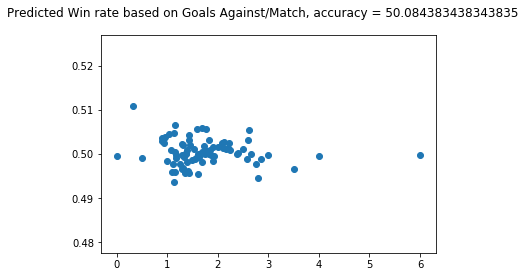

In [79]:
for v in variables:
    fig = plt.figure()
    ax = fig.add_subplot('111')
    ax.scatter(total[v].index, total[v]['Mean'])
    fig.suptitle("Predicted Win rate based on {}, accuracy = {}".format(v, accuracies.loc[v, 'Mean']))
    fig
# These scatter plots show how likely a team is to win as a percentage of one, based on all pre-2013 data.
# Note that python understands True as 1 and False as 0.
# The accuracy reflects how well we can predict the outcome of 2014 matches based on these percentages.

In [80]:
# How accurate each variable is at predicting 2014 outcomes
# The columns are the iterations
accuracies.sort_values(by='Mean', ascending=False)  
#I'm still bothered by the fact that Home always gets 75% accuracy

,0,1,2,3,4,5,6,7,8,9,...,1102,1103,1104,1105,1106,1107,1108,1109,1110,Mean
Home,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,...,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.000000
Wins,81.25,68.75,68.75,56.25,75.00,62.50,68.75,56.25,62.50,68.75,...,68.75,75.00,87.50,68.75,81.25,75.00,62.50,75.00,68.75,70.015752
Games Played,68.75,62.50,75.00,50.00,68.75,68.75,62.50,62.50,75.00,75.00,...,75.00,75.00,87.50,68.75,75.00,81.25,75.00,75.00,62.50,67.714896
Losses,62.50,56.25,68.75,50.00,62.50,62.50,62.50,56.25,75.00,81.25,...,75.00,68.75,81.25,68.75,56.25,75.00,75.00,75.00,56.25,60.817957
Foreign Coach,75.00,62.50,68.75,56.25,62.50,56.25,62.50,56.25,37.50,75.00,...,68.75,68.75,81.25,81.25,68.75,75.00,31.25,81.25,56.25,60.519802
Goals For/Match,56.25,75.00,43.75,56.25,50.00,68.75,68.75,50.00,43.75,31.25,...,62.50,62.50,50.00,75.00,87.50,56.25,31.25,75.00,56.25,56.188119
IH,43.75,68.75,81.25,50.00,37.50,68.75,56.25,75.00,37.50,31.25,...,81.25,56.25,43.75,68.75,31.25,62.50,31.25,75.00,56.25,54.725473
XP,43.75,43.75,37.50,43.75,68.75,43.75,50.00,56.25,50.00,62.50,...,56.25,62.50,56.25,68.75,56.25,43.75,56.25,68.75,68.75,53.679118
All Cards,43.75,43.75,43.75,37.50,43.75,37.50,62.50,56.25,25.00,62.50,...,68.75,43.75,62.50,68.75,50.00,56.25,37.50,62.50,81.25,53.319082
Y,43.75,43.75,43.75,37.50,56.25,37.50,62.50,56.25,25.00,62.50,...,68.75,37.50,43.75,68.75,50.00,56.25,31.25,62.50,81.25,52.705896


In [77]:
set(accuracies.loc['Home'])

{75.0}

In [47]:
# accuracies.T.to_csv("accuracies.csv")

In [48]:
teams.columns

Index(['Team', 'Team Initials', 'Win', 'Home', 'Goals For', 'Goals Against',
       'Win conditions', 'Referee', 'Opponent Name', 'Opponent Initials',
       'MatchID', 'Year', 'Datetime', 'Stage', 'Coach Name', 'Coach Country',
       'Foreign Coach', 'Y', 'RSY', 'R', 'I', 'IH', 'All Cards', 'Country',
       'newDateTime', 'Wins', 'Losses', 'Games Played', 'WinLoss%',
       'All Substitutions', 'Foreign Soil', 'Starting11', 'XP',
       'Goals For/Match', 'Goals Against/Match', 'Coach XP'],
      dtype='object')

In [49]:
teams

,Team,Team Initials,Win,Home,Goals For,Goals Against,Win conditions,Referee,Opponent Name,Opponent Initials,...,Losses,Games Played,WinLoss%,All Substitutions,Foreign Soil,Starting11,XP,Goals For/Match,Goals Against/Match,Coach XP
0,Argentina,ARG,True,True,6.0,1.0,,LANGENUS Jean (BEL),USA,USA,...,0,0,0.000000,0,False,"[ARGJuan BOTASSO0, ARGRodolfo ORLANDINI0, ARGF...",0,1.000000,1.000000,0
1,Uruguay,URU,True,True,6.0,1.0,,REGO Gilberto (BRA),Yugoslavia,YUG,...,0,0,0.000000,0,True,"[URUEnrique BALLESTRERO0, URUJose ANDRADE0, UR...",0,1.000000,1.000000,0
2,Uruguay,URU,True,True,4.0,2.0,,LANGENUS Jean (BEL),Argentina,ARG,...,0,1,1.000000,0,True,"[URUEnrique BALLESTRERO0, URUHector CASTRO0, U...",10,6.000000,1.000000,0
3,USA,USA,False,False,1.0,6.0,,LANGENUS Jean (BEL),USA,USA,...,0,0,0.000000,0,False,"[USAJimmy DOUGLAS0, USATom FLORIE0, USAJimmy G...",0,1.000000,1.000000,0
4,Yugoslavia,YUG,False,False,1.0,6.0,,REGO Gilberto (BRA),Yugoslavia,YUG,...,0,0,0.000000,0,False,"[YUGMilovan JAKSIC0, YUGBlagoje MARJANOVIC0, Y...",0,1.000000,1.000000,0
5,Argentina,ARG,False,False,2.0,4.0,,LANGENUS Jean (BEL),Argentina,ARG,...,0,1,1.000000,0,False,"[ARGJuan BOTASSO0, ARGFrancisco VARALLO0, ARGJ...",9,6.000000,1.000000,0
6,Austria,AUT,True,True,3.0,2.0,Austria win after extra time,VAN MOORSEL Johannes (NED),France,FRA,...,0,0,0.000000,0,False,"[AUTPeter PLATZER0, AUTJosef SMISTIK0, AUTToni...",0,1.000000,1.000000,0
7,Hungary,HUN,True,True,4.0,2.0,,BARLASSINA Rinaldo (ITA),Egypt,EGY,...,0,0,0.000000,0,False,"[HUNAntal SZABO0, HUNGabor SZABO0, HUNImre MAR...",0,1.000000,1.000000,0
8,Switzerland,SUI,True,True,3.0,2.0,,EKLIND Ivan (SWE),Netherlands,NED,...,0,0,0.000000,0,False,"[SUIFrank SECHEHAYE0, SUIWilly VON KAENEL0, SU...",0,1.000000,1.000000,0
9,Sweden,SWE,True,True,3.0,2.0,,BRAUN Eugen (AUT),Argentina,ARG,...,0,0,0.000000,0,False,"[SWEAnders RYDBERG0, SWESven ANDERSSON0, SWENi...",0,1.000000,1.000000,0


In [50]:
## Here's some code you could run to save the output of your analysis if you run it for a long time.
## Just update the filepaths.
# for v in variables:
#     total[v].to_csv('~/Desktop/Everything/SCS/finalproject/fifaworldcup/'+v+'.csv')
# accuracies.to_csv('~/Desktop/Everything/SCS/finalproject/fifaworldcup/accuracies.csv')

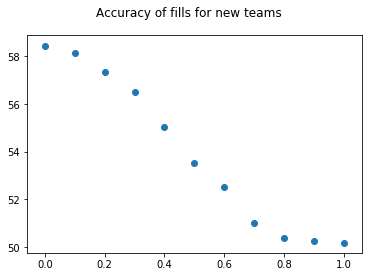

In [74]:
# This shows why I decided to fill the WinLoss% with 0 for teams with no previous elim game experience
fillpercentages = np.arange(0,1.1, 0.1)
its = {} # its stands for iterations, i.e., 0, 0.1, 0.2,...
for fill in fillpercentages:
    teams['Wins'] = 0
    teams['Losses'] = 0
    for row in teams.index:
        teamname = teams.loc[row, 'Team']
        teaminitials = teams.loc[row, 'Team Initials']
        currenttime = teams.loc[row, 'newDateTime']

        teams.loc[row, 'Wins'] = len(teams[(teams['Team']==teamname)&(teams['Team Initials']==teaminitials)&\
                                          (teams['Win']==True)&(teams['newDateTime']<currenttime)])
        teams.loc[row, 'Losses'] = len(teams[(teams['Team']==teamname)&(teams['Team Initials']==teaminitials)&\
                                          (teams['Win']==False)&(teams['newDateTime']<currenttime)])

    teams['Games Played'] = teams['Wins'] + teams['Losses']
    for row in teams.index:
        if teams.loc[row, 'Games Played'] == 0:
            # I don't know if 0.5 is right
            teams.loc[row, 'WinLoss%'] = fill
        else:    
            teams.loc[row, 'WinLoss%'] = teams.loc[row, 'Wins']/teams.loc[row, 'Games Played']
            accuracy_data = {}
            
    variables1 = ['WinLoss%']
    
    total1 = {}
    for variable in variables:
        total1[variable] = DataFrame()
    seed(12345)
    iterations = 100
    for i in range(iterations): 
        # reduce teams by half, randomly choosing one team from each match
        accumulator = {}
        index = 0
        for id_ in list(set(teams[teams['Year']>1953]['MatchID'])):
            match = teams[teams['MatchID']==id_]
            accumulator[index] = match.iloc[randint(0,1)]
            index += 1

        halfteams = DataFrame.from_dict(accumulator, orient='index')
        # split out the training dataset and the test data base
        teams_train = halfteams[halfteams['Year'] < 2013]
        teams_test  = halfteams[halfteams['Year'] > 2013]
        
        variable_accuracies = []
        for variable in variables1:
            analysis = analyze(variable)
            total1[variable][i] = analysis['probdf_column'].Win
            variable_accuracies.append(analysis['Accuracy'])
        accuracy_data[i] = Series([round(100*x) for x in variable_accuracies], index=variables1)


    accuracies1 = DataFrame.from_dict(accuracy_data, orient='columns')
    accuracies1['Mean'] = accuracies1.mean(axis=1)


    for variable in variables1:
        total1[variable]['Mean'] = total[variable].mean(axis=1)
    its[fill] = accuracies1['Mean']

fig = plt.figure()
ax = fig.add_subplot('111')
ax.scatter(its.keys(), [its[key] for key in its.keys()])
fig.suptitle("Accuracy of fills for new teams")
# fig.savefig("Accuracy of fills for new teams", dpi=600)

In [82]:
# matches.head().to_csv("MatchesHead.csv")
# cups.head().to_csv("CupsHead.csv")
# players.head().to_csv("PlayersHead.csv")
# data1.head().to_csv("EventsHead.csv")
# teams.head().to_csv("TeamsHead.csv")